# FNC 8.7 — Exercises 4, 5(a), 6(b,c) (Python Notebook)

This notebook answers the **programming** exercises from **FNC 8.7 — Matrix-free iterations**.

- Written exercises **1–3**, **5(b,c)**, and **6(a)** are answered in `习题解答/na_sol_datahub_8/main.tex`.

We repeat Demo 8.7.2 (deblurring) using **CG**, and solve a matrix-free linear system for `cumsum` using **GMRES**.


In [1]:
# If you're running locally and miss a dependency, uncomment the next line.
# %pip install --index-url https://pypi.org/simple numpy scipy matplotlib scikit-image

import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse
from scipy.sparse.linalg import LinearOperator, cg, gmres

from skimage import data, color, transform


## Helpers: blur matrices and matrix-free operators

In [2]:
def blur_matrix(d: int) -> sparse.csr_matrix:
    main = 0.5 * np.ones(d)
    off = 0.25 * np.ones(d - 1)
    return sparse.diags([off, main, off], offsets=[-1, 0, 1], format='csr')


def sparse_power(A: sparse.spmatrix, k: int) -> sparse.spmatrix:
    if k < 0:
        raise ValueError('k must be nonnegative')
    if k == 0:
        return sparse.identity(A.shape[0], format='csr')
    P = A.copy()
    for _ in range(1, k):
        P = (P @ A).tocsr()
    return P


def blur_apply(X: np.ndarray, Bk: sparse.spmatrix, Ck: sparse.spmatrix) -> np.ndarray:
    # blur(X) = B^k * X * C^k
    return (Bk @ X) @ Ck


def make_blur_operator(m: int, n: int, Bk, Ck) -> LinearOperator:
    N = m * n

    def matvec(x):
        X = x.reshape(m, n)
        Z = blur_apply(X, Bk, Ck)
        return Z.reshape(N)

    return LinearOperator((N, N), matvec=matvec, dtype=float)


def run_cg(op: LinearOperator, b: np.ndarray, *, rtol: float, maxiter: int):
    b = np.asarray(b, dtype=float).reshape(-1)
    bnorm = float(np.linalg.norm(b))
    hist = []

    def cb(xk):
        r = b - op @ xk
        hist.append(float(np.linalg.norm(r)) / bnorm)

    x, info = cg(op, b, rtol=rtol, atol=0.0, maxiter=maxiter, callback=cb)
    return x, np.array(hist), info


def run_gmres(op: LinearOperator, b: np.ndarray, *, rtol: float, maxiter: int):
    b = np.asarray(b, dtype=float).reshape(-1)
    bnorm = float(np.linalg.norm(b))
    hist = []

    def cb(xk):
        r = b - op @ xk
        hist.append(float(np.linalg.norm(r)) / bnorm)

    x, info = gmres(op, b, rtol=rtol, atol=0.0, restart=None, maxiter=maxiter, callback=cb, callback_type='x')
    return x, np.array(hist), info


## Exercise 4 — Deblurring via CG (matrix-free)

We build the blur operator

\[\mathrm{blur}(X)=B^k X C^k\]

and solve `blur(Y) = Z` for `Y` using **CG** on a `LinearOperator`.


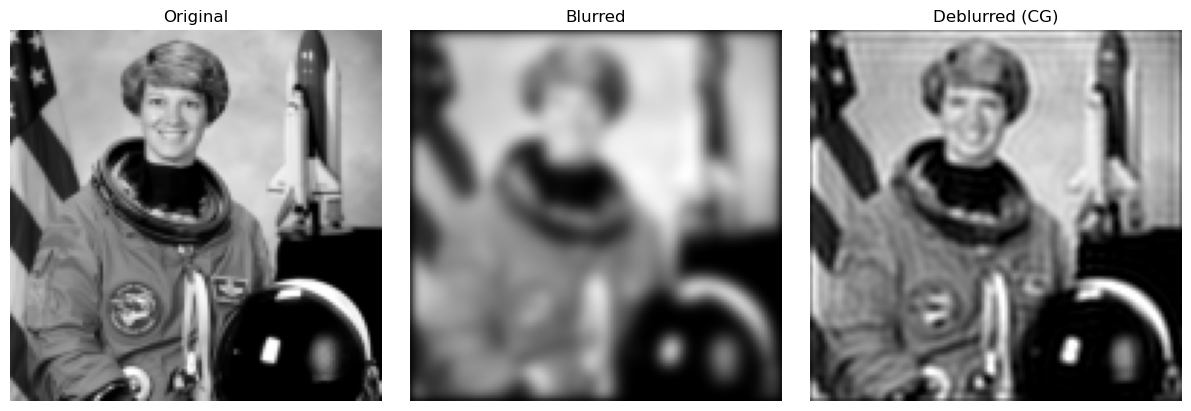

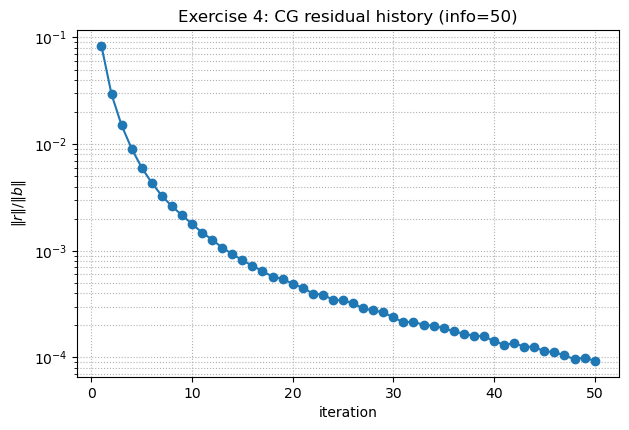

In [3]:
# Load a test image and convert to grayscale in [0,1]
img = data.astronaut()
X0 = color.rgb2gray(img)
X = transform.resize(X0, (128, 128), anti_aliasing=True)

m, n = X.shape
k = 12

B = blur_matrix(m)
C = blur_matrix(n)

Bk = sparse_power(B, k)
Ck = sparse_power(C, k)

Z = blur_apply(X, Bk, Ck)

op = make_blur_operator(m, n, Bk, Ck)

# Solve blur(Y)=Z using CG
z_vec = Z.reshape(m * n)
y_vec, relhist, info = run_cg(op, z_vec, rtol=1e-5, maxiter=50)
Y = y_vec.reshape(m, n)
Y = np.clip(Y, 0.0, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
axes[0].imshow(X, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(Z, cmap='gray')
axes[1].set_title('Blurred')
axes[1].axis('off')
axes[2].imshow(Y, cmap='gray')
axes[2].set_title('Deblurred (CG)')
axes[2].axis('off')
plt.show()

plt.figure(figsize=(7, 4.5))
plt.semilogy(np.arange(1, len(relhist) + 1), relhist, marker='o')
plt.grid(True, which='both', ls=':')
plt.xlabel('iteration')
plt.ylabel(r'$\|r\|/\|b\|$')
plt.title(f'Exercise 4: CG residual history (info={info})')
plt.show()


## Exercise 5(a) — Condition number of the 1D blur matrix

Let m=50 and B be the tridiagonal blur matrix from (8.7.2). Show B is SPD (via Cholesky) and compute κ(B).


In [4]:
m = 50
B = blur_matrix(m).toarray()

# Cholesky test for SPD
L = np.linalg.cholesky(B)

kappa = np.linalg.cond(B, 2)

print('Cholesky factor L shape:', L.shape)
print('kappa_2(B) =', kappa)


Cholesky factor L shape: (50, 50)
kappa_2(B) = 1053.4789912001122


## Exercise 6(b,c) — Inverting `cumsum` with GMRES (matrix-free)

Define f(x)=cumsum(x), i.e.

\[f(x) = [x_1, x_1+x_2, \dots, x_1+\cdots+x_n]^T.\]

Let b_i = (i/100)^2 for i=1,…,100. Use GMRES to solve f(x)=b, then plot x.


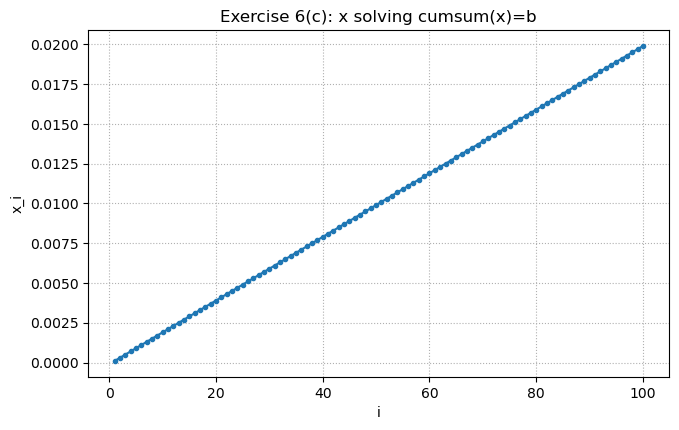

GMRES info = 0
||x - x_exact|| / ||x_exact|| = 4.9835318719438785e-11


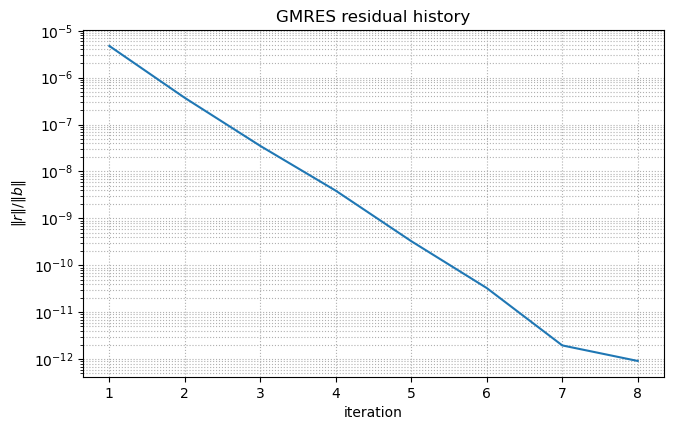

In [5]:
n = 100
b = (np.arange(1, n + 1) / 100.0) ** 2

# LinearOperator for cumsum
op = LinearOperator((n, n), matvec=lambda x: np.cumsum(x), dtype=float)

x, relhist, info = run_gmres(op, b, rtol=1e-12, maxiter=200)

plt.figure(figsize=(7.5, 4.5))
plt.plot(np.arange(1, n + 1), x, marker='o', markersize=3)
plt.grid(True, ls=':')
plt.xlabel('i')
plt.ylabel('x_i')
plt.title('Exercise 6(c): x solving cumsum(x)=b')
plt.show()

# sanity check: exact inverse is first-difference
x_exact = np.empty_like(b)
x_exact[0] = b[0]
x_exact[1:] = b[1:] - b[:-1]
print('GMRES info =', info)
print('||x - x_exact|| / ||x_exact|| =', np.linalg.norm(x - x_exact) / np.linalg.norm(x_exact))

plt.figure(figsize=(7.5, 4.5))
plt.semilogy(np.arange(1, len(relhist) + 1), relhist)
plt.grid(True, which='both', ls=':')
plt.xlabel('iteration')
plt.ylabel(r'$\|r\|/\|b\|$')
plt.title('GMRES residual history')
plt.show()
